# Deep Learning Forecast

##### Created by: Roberto Medina - EDP UNGE - DSO. January 14, 2019.
#####  Description
The goal of this script is to serve as a tutorial on forecasting energy prices for each hour of the day-ahead Spanish market.

##### Data sources: 
OMIE Mercado Diario historical data, fetched through the EDP-DSO's application TDMI. 
PRECO_ES, PRECO_PT, and ENERGY is available for each day and hour.  A UiPath bot has been created for this step.

##### Model inputs: 
DATA, HORA, PRECO_PT, PRECO_ES, ENERGY, Wind_ES, and variables engineered from averages and lags of these variables.

##### Model outputs: 
PRECO_ES_1fut, for each hour of the next day.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Iterable
import itertools
import seaborn as sns
from sklearn.utils import indexable
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from graphviz import *
from copy import *
import datetime
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline 


Using TensorFlow backend.


# Load Data

In [2]:
df1 = pd.read_excel('C:/Users/E351722/OneDrive - EDP/REN_prediction/MercadoEnergiaDiario.xls',  sheet_name='Report 1', converters={'Unnamed1':str, 
                                                                                        'Date':str,
                                                                                        'Hour':str,
                                                                                        'PRECO_ES':str,
                                                                                        'PRECO_PT':str,
                                                                                        'ENERGY':str,
                                                                                        'Unnamed2':str})

df1 = df1.drop(['Unnamed: 0'],1)

df1.columns = ['DATA', 'HORA','PRECO_ES', 'PRECO_PT', 'ENERGY']

df1.DATA =  pd.DatetimeIndex(df1['DATA'])

df1.HORA = df1.HORA.astype('int')
df1.PRECO_ES = df1.PRECO_ES.astype('float32')
df1.PRECO_PT = df1.PRECO_PT.astype('float32')
df1.ENERGY = df1.ENERGY.astype('float32')

df1.tail()


WARNING *** file size (3772520) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,DATA,HORA,PRECO_ES,PRECO_PT,ENERGY
28820,2019-01-12,20,69.449997,69.449997,29154.699219
28821,2019-01-12,21,69.690002,69.690002,29905.800781
28822,2019-01-12,22,69.449997,69.449997,29848.099609
28823,2019-01-12,23,68.709999,68.709999,28924.000000
28824,2019-01-12,24,67.830002,67.830002,26672.300781


In [3]:
df2 = pd.read_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/MercadoEnergiaDiario.xls', sheet_name='Report 2', converters={'Unnamed1':str, 
                                                                                        'Market Date':str,
                                                                                        'Market Hour':str,
                                                                                        'Energy (MWh)':str,
                                                                                        'Unnamed2':str})

df2 = df2.drop(['Unnamed: 0'],1)

df2.columns = ['DATA', 'HORA', 'Wind_ES']

df2.DATA =  pd.DatetimeIndex(df2['DATA'])
df2.HORA = df2.HORA.astype('int')
df2.Wind_ES = df2.Wind_ES.astype('float32')

df2.tail()


WARNING *** file size (3772520) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,DATA,HORA,Wind_ES
10844,2019-01-25,21,13062.817383
10845,2019-01-25,22,12965.634766
10846,2019-01-25,23,12866.150391
10847,2019-01-25,24,12792.606445
10848,2019-01-26,1,12731.644531


In [4]:
df3 = pd.read_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/MercadoEnergiaDiario.xls', sheet_name='Report 3', converters={'Unnamed1':str, 
                                                                                        'Market Date':str,
                                                                                        'Market Hour':str,
                                                                                        'Quantity':str,
                                                                                        'Unnamed2':str})

df3 = df3.drop(['Unnamed: 0'],1)

df3.columns = [ 'Market Date', 'Marker Hour', 'Meteo_Forecast']

df3.columns = [ 'DATA', 'HORA','Meteo_Forecast']

df3.DATA =  pd.DatetimeIndex(df3['DATA'])
df3.HORA = df3.HORA.astype('int')
df3.Meteo_Forecast = df3.Meteo_Forecast.astype('float32')


df3.tail()

WARNING *** file size (3772520) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,DATA,HORA,Meteo_Forecast
10845,2019-01-25,22,8805.570312
10846,2019-01-25,23,8396.617188
10847,2019-01-25,24,7908.465820
10848,2019-01-26,1,7141.893066
10849,2019-01-26,2,6444.107910


In [5]:
df4 = pd.read_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/MercadoEnergiaDiario.xls', sheet_name='Report 4', converters={'Unnamed1':str, 
                                                                                        'Market Date':str,
                                                                                        'Market Hour':str,
                                                                                        'Percentil':str,
                                                                                        'Price':str,
                                                                                        'Unnamed2':str})

df4 = df4.drop(['Unnamed: 0'],1)


df4.columns = ['Market Date', 'Marker Hour', 'Percentil', 'Price_Forecast_FR']

df4 = df4.drop([ 'Percentil'],1)
df4.columns = [ 'DATA', 'HORA','Price_Forecast_FR']

df4.DATA =  pd.DatetimeIndex(df4['DATA'])
df4.HORA = df4.HORA.astype('int')
df4.Price_Forecast_FR = df4.Price_Forecast_FR.astype('float32')


df4.tail()

WARNING *** file size (3772520) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,DATA,HORA,Price_Forecast_FR
10845,2019-01-25,22,67.599998
10846,2019-01-25,23,67.000000
10847,2019-01-25,24,65.800003
10848,2019-01-26,1,63.000000
10849,2019-01-26,2,59.400002


In [6]:
xls = pd.ExcelFile('C:/Users/e351722/OneDrive - EDP/REN_prediction/gen_SPOT_ES.xls')

# Now you can list all sheets in the file
xls.sheet_names

df5 = pd.read_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/gen_SPOT_ES.xls', sheet_name=xls.sheet_names[0])
print(df5.tail())

df5.columns = ['Unknown', 'DATA', 'Unit','Valor_Spot']

df5 = df5.drop(['Unknown'],1)

df5.DATA =  pd.DatetimeIndex(df5['DATA'])
df5.Unit = df5.Unit.astype('str')
df5.Valor_Spot = df5.Valor_Spot.astype('float32')

# we will create daily horizontal features out of the column 'Unit' by using a pivot table
newdf = pd.pivot_table(df5, index=['DATA'], columns = 'Unit')
newdf = newdf.reset_index()
newdf.tail(100)

dfmerged = pd.merge(df1[['DATA','HORA']], newdf, how='left', on = ['DATA'])
df5 = dfmerged
list(df5)

WARNING *** file size (2752770) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (2752770) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
       Unnamed: 0 Data Cotação  \
41834         NaN   2019-01-13   
41835         NaN   2019-01-13   
41836         NaN   2019-01-13   
41837         NaN   2019-01-14   
41838         NaN   2019-01-14   

                                Indicador SPOT (Unidade)  Valor Spot (Média)  
41834  Preços de Energia Mercado Diário – Portugal - ...           66.193333  
41835     Taxa de Câmbio EUR / GBP - Reuters - 1EUR=xGBP            0.891780  
41836     Taxa de Câmbio EUR / USD - Reuters - 1EUR=xUSD            1.145920  
41837     Taxa de Câmbio EUR / GBP - Reuters - 1EUR=xGBP            0.892760  
41838     Taxa de Câmbio EUR / USD - Reuters - 1EUR=xUSD            1.146820  


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['DATA',
 'HORA',
 ('Valor_Spot', 'Baltic DRY Index - Reuters - n.a.'),
 ('Valor_Spot', 'Baltic DRY Index - n.a.'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Áustria - Luxemburgo) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Bélgica (Bélgica) - EUR/MWH'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Eslovênia (Eslovênia) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Espanha (Espanha) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - França (França) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Hungria (Hungria) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Irlanda (Irlanda) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Itália (Itália-1) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Itália (Itália-2) - EUR/MWH'),
 ('Valor_Spot'

In [7]:
# Join Data Frames. Left join on df2 because it has future data that df1 does not.
df = pd.merge(df2, df1, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df3, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df4, how='left', on = ['DATA', 'HORA'])

df = pd.merge(df, df5, how='left', on = ['DATA', 'HORA'])

# Feature Engineering

In [8]:
# First let's create day averages for the target variable PRECO_ES
daydata2=df1.groupby(['DATA']).PRECO_ES.mean()
daydata2.name = 'DAY_MEAN_ES'
df_daily2 = pd.DataFrame(daydata2)
df1 = pd.merge(df1, df_daily2, how='left', on = ['DATA'])

### Create lagged variables (and rolling averages) for each value of PRECO_ES (i.e. for each day and hour)

In [9]:
lag = [7]
df_new = deepcopy(df)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df[['DATA','HORA']], df_new], axis = 1)
df = df_new
list(df)

['DATA',
 'HORA',
 'Wind_ES',
 'PRECO_ES',
 'PRECO_PT',
 'ENERGY',
 'Meteo_Forecast',
 'Price_Forecast_FR',
 ('Valor_Spot', 'Baltic DRY Index - Reuters - n.a.'),
 ('Valor_Spot', 'Baltic DRY Index - n.a.'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Áustria - Luxemburgo) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Bélgica (Bélgica) - EUR/MWH'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Eslovênia (Eslovênia) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Espanha (Espanha) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - França (França) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Hungria (Hungria) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Irlanda (Irlanda) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Itália (Itália-1) - EUR/MWH'),

### Create future lag variable PRECO_ES_1fut.  This is the target variable y we want to predict.
#### Do this also for any variables for which future values are available, e.g Meteo_Forecast

In [10]:
# Eliminate NA's from Target Variable
df['PRECO_ES'] = df.PRECO_ES.fillna(0).replace(np.inf, 0)
# Create Y(t+1), the variable we want to predict
df['PRECO_ES_1fut']=df.groupby([ 'HORA'])['PRECO_ES'].shift(-1)
# Create X(t+1), for variables we have future values of
df['Wind_ES_1fut']=df.groupby([ 'HORA'])['Wind_ES'].shift(-1)
df['Meteo_Forecast_1fut']=df.groupby([ 'HORA'])['Meteo_Forecast'].shift(-1)
df['Price_Forecast_FR_1fut']=df.groupby([ 'HORA'])['Price_Forecast_FR'].shift(-1)

df_w_labels = deepcopy(df)
df_copy = deepcopy(df)
df_copy_labels = deepcopy(df)

df['date'] = pd.DatetimeIndex(df['DATA'])
df['day'] = df['date'].apply(lambda x: x.day)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
#df['dayofyear'] = df['date'].apply(lambda x: x.dayofyear)
#df['month'] = df['date'].apply(lambda x: x.month)
#df['year'] = df['date'].apply(lambda x: x.year)

### Visualize correlations in dataframe df

#### The last row is our target variable PRECO_ES_1fut, labeled PRECO_ES_D+1 in this plot

colormap = plt.cm.RdBu

plt.figure(figsize=(23,23))
plt.title(u'Cross Correlogram', y=1.05, size=16)

df_new = df.dropna()
df_new['PRECO_ES_D+1'] = df_new.groupby([ 'HORA'])['PRECO_ES'].shift(-1)
mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, vmin=-1,
            square=True, cmap=colormap, linecolor='white', annot=True)

### Drop variables with poor correlation to the target variable


In [11]:
# drop low correlated lag variable
#df = df.drop(['PRECO_PT_365'],1)
df_new = df.drop(columns=['DATA', 'date'], axis=1) 
a=np.abs(df_new.corr().PRECO_ES_1fut)<.1
dropvariables = df.fillna(df.mean()).corr()[a==True].index[:-1]
# list dropped variables
list(dropvariables)

[('Valor_Spot', 'Preço diário do Gás Natural Henry Hub - $/MMBTU'),
 ('Valor_Spot', 'Preço diário do Gás Natural Henry Hub - Reuters - $/MMBTU'),
 ('Valor_Spot', 'Taxa de Câmbio EUR / HRK - 1EUR=xHRK'),
 ('Valor_Spot', 'Taxa de Câmbio EUR / IDR - 1EUR=xIDR'),
 ('Valor_Spot', 'Taxa de Câmbio EUR / MYR - 1EUR=xMYR'),
 ('Valor_Spot', 'Taxa de Câmbio EUR / NOK - 1EUR=xNOK'),
 'ENERGY_7',
 "('Valor_Spot', 'Preço diário do Gás Natural Henry Hub - $/MMBTU')_7",
 "('Valor_Spot', 'Preço diário do Gás Natural Henry Hub - Reuters - $/MMBTU')_7",
 "('Valor_Spot', 'Taxa de Câmbio EUR / HRK - 1EUR=xHRK')_7",
 "('Valor_Spot', 'Taxa de Câmbio EUR / IDR - 1EUR=xIDR')_7",
 "('Valor_Spot', 'Taxa de Câmbio EUR / MYR - 1EUR=xMYR')_7",
 "('Valor_Spot', 'Taxa de Câmbio EUR / NOK - 1EUR=xNOK')_7",
 'day']

In [12]:
df=df.drop(df[dropvariables[:-1]],axis=1)
# list remaining variables
list(df)

['DATA',
 'HORA',
 'Wind_ES',
 'PRECO_ES',
 'PRECO_PT',
 'ENERGY',
 'Meteo_Forecast',
 'Price_Forecast_FR',
 ('Valor_Spot', 'Baltic DRY Index - Reuters - n.a.'),
 ('Valor_Spot', 'Baltic DRY Index - n.a.'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Áustria - Luxemburgo) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Bélgica (Bélgica) - EUR/MWH'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH'),
 ('Valor_Spot',
  'ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Eslovênia (Eslovênia) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Espanha (Espanha) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - França (França) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Hungria (Hungria) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Irlanda (Irlanda) - EUR/MWH'),
 ('Valor_Spot', 'ENTSOE: Day Ahead Prices - Itália (Itália-1) - EUR/MWH'),

# Set Dates for Training and Testing splits

In [13]:
pred_date_END = np.max(df1.DATA)-timedelta(1) # PRECO_ES_1fut is undefined for the last day, so we test on max(date)-1

pred_date_START =  pred_date_END  - timedelta(6) # number of days for back-testing prediction, 0 means only the last day is used
                                                 # I recommend to use 7 when prototyping, and 0 for production
last_train_date = pred_date_START - timedelta(1) # All the data available minus the last day will be used for training

first_train_date =   pred_date_END - timedelta(395) # 395 days of historical data used. More days does not improve prediction.


## Split training,  testing, and prediction data 


In [14]:
train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]
X_train.head()

,HORA,Wind_ES,PRECO_ES,PRECO_PT,ENERGY,Meteo_Forecast,Price_Forecast_FR,"(Valor_Spot, Baltic DRY Index - Reuters - n.a.)","(Valor_Spot, Baltic DRY Index - n.a.)","(Valor_Spot, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Áustria - Luxemburgo) - EUR/MWH)",...,"('Valor_Spot', 'Taxa de Câmbio EUR / XAF - Reuters - 1EUR=xXAF')_7","('Valor_Spot', 'Taxa de Câmbio EUR / ZAR - 1EUR=xZAR')_7","('Valor_Spot', 'Taxa de Câmbio USD / EUR - Reuters - 1USD=xEUR')_7","('Valor_Spot', 'Taxa de Juros MIBOR Overnight INR - Percentage')_7","('Valor_Spot', 'Taxa de Juros WIBOR Overnight PLN - Percentage')_7",Wind_ES_1fut,Meteo_Forecast_1fut,Price_Forecast_FR_1fut,day,dayofweek
1008,1,9023.347656,53.980000,53.980000,28430.150391,6190.313965,59.000000,1743.0,1743.0,26.875,...,657.0,16.0618,0.84908,6.05,1.606667,6991.883789,6441.048828,64.599998,12,1
1009,2,8780.034180,50.619999,50.619999,26955.099609,5563.646973,59.799999,1743.0,1743.0,26.875,...,657.0,16.0618,0.84908,6.05,1.606667,6905.151855,5828.733887,60.599998,12,1
1010,3,8442.606445,49.279999,49.279999,25440.849609,5200.107910,58.099998,1743.0,1743.0,26.875,...,657.0,16.0618,0.84908,6.05,1.606667,6853.397949,5427.759766,58.099998,12,1
1011,4,8093.694824,48.689999,48.689999,24656.800781,4983.890137,51.700001,1743.0,1743.0,26.875,...,657.0,16.0618,0.84908,6.05,1.606667,7050.132812,5215.166992,50.500000,12,1
1012,5,8171.030762,48.689999,48.689999,24525.300781,4902.365234,51.200001,1743.0,1743.0,26.875,...,657.0,16.0618,0.84908,6.05,1.606667,7420.804199,5099.074219,48.599998,12,1


# Apply PCA to Data and Split Training, Testing, and Forecasting (pred) sets

In [15]:
#first_train_date = last_train_date - timedelta(90)

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())
train = train.fillna(0)

from sklearn.decomposition import PCA
pca = PCA(0.95)  # keep components that explain 95% of the variance
datas = train.drop(['date','PRECO_ES_1fut'],1)
data_pca = pca.fit(datas)
PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
#train = train.reset_index(drop=True)
#list(train)

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())
df_test = df_test.fillna(0)

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

test_pca = data_pca.transform(test.drop(['date','PRECO_ES_1fut'],1))

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

prediction_pca = data_pca.transform(prediction_set.drop(['date', 'PRECO_ES_1fut'],1))

train_pca = data_pca.transform(train.drop(['date','PRECO_ES_1fut'],1))


train = pd.concat([train.reset_index(), pd.DataFrame(train_pca)], axis=1)
test = pd.concat([test.reset_index(), pd.DataFrame(test_pca)], axis=1)
prediction_set = pd.concat([prediction_set.reset_index(), pd.DataFrame(prediction_pca)], axis=1)


train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)

train = train.drop(['index'],1)
test = test.drop(['index'],1)
prediction_set=prediction_set.drop(['index'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

X_test.head()

[0.53098645 0.31128236 0.10468563 0.02500103]


,HORA,Wind_ES,PRECO_ES,PRECO_PT,ENERGY,Meteo_Forecast,Price_Forecast_FR,"(Valor_Spot, Baltic DRY Index - Reuters - n.a.)","(Valor_Spot, Baltic DRY Index - n.a.)","(Valor_Spot, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Áustria - Luxemburgo) - EUR/MWH)",...,"('Valor_Spot', 'Taxa de Juros WIBOR Overnight PLN - Percentage')_7",Wind_ES_1fut,Meteo_Forecast_1fut,Price_Forecast_FR_1fut,day,dayofweek,0,1,2,3
0,1,3516.084961,71.68,71.68,26434.599609,6780.816895,59.500000,1260.0,1260.0,41.7425,...,1.473333,9047.264648,6458.105957,57.700001,5,5,-2338.220672,-1712.715740,4263.324799,613.050109
1,2,3554.291016,69.50,69.50,23888.099609,5919.763184,46.299999,1260.0,1260.0,41.7425,...,1.473333,8942.276367,5585.012207,48.900002,5,5,-3155.899925,989.402905,3907.872977,734.596912
2,3,3648.656006,68.07,68.07,22099.500000,5509.324219,44.900002,1260.0,1260.0,41.7425,...,1.473333,8818.358398,5189.347168,47.799999,5,5,-3707.510955,2813.433652,3642.154850,692.151073
3,4,3837.895020,66.00,66.00,20919.599609,5249.248047,42.099998,1260.0,1260.0,41.7425,...,1.473333,8729.504883,4923.812012,46.200001,5,5,-4211.984549,3932.693334,3620.455822,367.515589
4,5,4155.823242,63.93,63.93,20385.699219,5139.229004,41.599998,1260.0,1260.0,41.7425,...,1.473333,8643.000000,4813.842773,42.900002,5,5,-4538.325869,4368.678926,3699.006375,-127.893302


# Normalze variables, Final Preprocessing Step, needed for Neural Networks

In [16]:
# we create sets x_train_c, x_test_c, and x_pred_c by copying X_train and X_test and then normalizing the copies.

x_train_c= deepcopy(X_train)
x_test_c = deepcopy(X_test)
x_pred_c = deepcopy(X_pred)

from sklearn import preprocessing

# Normalize Training Data 
train_norm = x_train_c[x_train_c.columns[:]]
test_norm = x_test_c[x_test_c.columns[:]]
pred_norm = x_pred_c[x_pred_c.columns[:]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
x_train_c.update(training_norm_col)

# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test_c.update(testing_norm_col)

# Normalize Prediction Data by using mean and SD of training set
x_pred_norm = std_scale.transform(pred_norm)
pred_norm_col = pd.DataFrame(x_pred_norm, index=pred_norm.index, columns=pred_norm.columns) 
x_pred_c.update(pred_norm_col)

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int32, int64, float32, float64 were all converted to float64 by StandardScaler.
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int32, int64, float32, float64 were all converted to float64 by Standa

# Build Random Forest Regression Model

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def prediction_rfregression(x_train, y_train, x_test, y_test):
    """
    Machine learning implementation - RandomForestRegressor algorithm.

    :param x_train: Predictors train.
    :param y_train: Response variable train.
    :param x_test: Predictors test.
    :param y_test: Response variable test.
    :return: The RandomForest Regression model.
    """

    cv_splits = 5
    clf = RandomForestRegressor()
    
    # Defining the grid search    
    param_grid = {'max_depth': [10]
                  }
    
    print('Model training')

    tree_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                             iid=False, refit=True, cv=cv_splits, verbose=5, n_jobs = -1) #, scoring='neg_mean_squared_error'
    tree = tree_grid.fit(x_train, y_train)
    
    print(tree.best_params_)
    tree_predict = tree.predict(x_test)
    features = tree.estimator.fit(x_train, y_train).feature_importances_
    feature_imp_df = pd.DataFrame({'Importance': features},
                                  index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    print(feature_imp_df)
    print('\n', 'r2_score:', r2_score(y_test, tree_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, tree_predict), '\n')
    MAP_error = mean_absolute_percentage_error(y_test, tree_predict)
    
    print('\n')
    
    d_price = x_test['PRECO_ES']

    print('\n',
          'mean_absolute_percentage_error Naive (D)', mean_absolute_percentage_error(y_test, d_price), '\n')

    print('\n')
    test_vs_model_plot(y_test, tree_predict)
    print('\n')
    model_plot(x_test, y_test, tree_predict)
    print('\n')
   
    return tree_predict, y_test, tree, MAP_error


def model_plot(x, y, tree_predict):

    plt.figure()
    plt.scatter( y, x['PRECO_ES'], c="cornflowerblue", label="Naive (D)")
    plt.scatter( y, tree_predict, color="darkorange", label="RandomForest", linewidth=2)
    plt.xlabel("Actual D+1 Price")
    plt.ylabel("Predicted D+1 Price")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()
    
    return None


def test_vs_model_plot(y_test, tree_predict):
    max_x = max(y_test)
    min_x = min(y_test)
    max_y = max(tree_predict)
    min_y = min(tree_predict)
    plt.figure()
    plt.scatter(y_test, tree_predict, c="darkorange", label="test data")
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.plot([min_x, max_x], [min_x, max_x], 'k--')

    plt.xlabel("Actual D+1 Price")
    plt.ylabel("Predicted D+1 Price")
    plt.title("Decision Tree")
    plt.legend()
    #plt.savefig('fig.png')  # save the figure to file
    plt.show()
     
    plt.figure()
    plt.plot(y_test, c="black", label="Actual")
    plt.plot(tree_predict, c="darkorange", label="RF Prediction")
    plt.legend()

    plt.show()

    return None


# Train and Run RF Model

Model training
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'max_depth': 10}


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                                                      Importance
(Valor_Spot, Preços de Energia Mercado Diário –...  2.027814e-01
(Valor_Spot, Preços de Energia Mercado Diário –...  1.987475e-01
(Valor_Spot, ENTSOE: Day Ahead Prices - Espanha...  1.856759e-01
PRECO_PT                                            1.013979e-01
(Valor_Spot, ENTSOE: Day Ahead Prices - Portuga...  5.275138e-02
HORA                                                4.253326e-02
Price_Forecast_FR_1fut                              3.051510e-02
PRECO_ES                                            2.740238e-02
Wind_ES_1fut                                        2.648402e-02
Meteo_Forecast_1fut                                 2.605696e-02
2                                                   1.550211e-02
1                                                   9.403119e-03
('Valor_Spot', 'Preços de Energia Mercado Diári...  4.167986e-03
Meteo_Forecast_7                                    4.145305e-03
Meteo_Forecast           

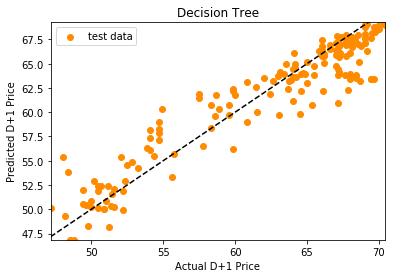

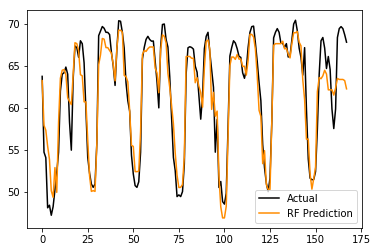

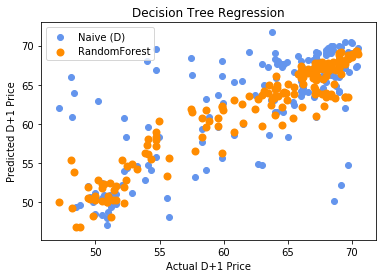

In [18]:
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
test_predicted_rf, y_test, tree, MAP_error_rf = prediction_rfregression(X_train, y_train, X_test, y_test)

# RandomForest Day-Ahead Forecast

In [19]:
rf_prediction = list(tree.predict(X_pred))

# Build Deep Neural Network Regression 

In [20]:
def dnn_prediction(list_var):
    """
    SKLearn MLPRegressor algorithm.

    :param list_var: List with the test and train components.
    :return: The Deep Neural Network model.
    """
    # Unpacking the variables
    x_train_c, y_train, x_test_c, y_test = list_var

    # Computing Number of Neurons in Hidden Layers
    #
    # One issue within this subject on which there is a consensus is the 
    # performance difference from adding additional hidden layers: the situations
    # in which performance improves with a second (or third, etc.) hidden layer are very few.
    #
    # One hidden layer is sufficient for the large majority of problems.
    # 0 - Only capable of representing linear separable functions or decisions.
    # 1 - Can approximate any function that contains a continuous mapping
    # from one finite space to another.
    # 2 - Can represent an arbitrary decision boundary to arbitrary accuracy
    # with rational activation functions and can approximate any smooth
    # mapping to any accuracy.    
    #
    # One hidden layer is sufficient for the large majority of problems.   
    
    cv_splits = 4
    hl_scaling = 2
    input_layer = np.shape(x_train_c)[1]
    output_layer = 1
    middle_hidden_layer = round((np.shape(x_train_c)[0])/(hl_scaling*(np.shape(x_train_c)[1]+output_layer)))
    #middle_hidden_layer_2 = round(middle_hidden_layer/2)  # optional - place between middle_hidden_layer and output_layer below
    
    # Defining the number of neurons in the hidden layer using formula:
    # Nh=Ns(α∗(Ni+No))
    # derived from this guide on preventing overfitting http://hagan.okstate.edu/NNDesign.pdf#page=469 

    clf = MLPRegressor( hidden_layer_sizes=(input_layer,middle_hidden_layer, middle_hidden_layer, output_layer),  activation='identity',
                       solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.0001,
                       power_t=0.5, max_iter=1000, shuffle=True, random_state=9, tol=0.0001, verbose=False, warm_start=False,
                       momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.2, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
    
    # Set the parameters of the neural network
    # default parameters used unless stated above in clf
    # see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
    param_grid = {}
    
    dnn_grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, iid=True, refit=True,
                            cv=cv_splits, scoring='neg_mean_absolute_error', verbose = 5)

    dnn_fit = dnn_grid.fit(x_train_c, y_train)
    
    #dnn_grid.fit(x_train_c, y_train)

    # Printing the best parameters of the model

    # Predicting the data using the test data
    dnn_predict = dnn_fit.predict(x_test_c)
    MAP_error = mean_absolute_percentage_error(y_test, dnn_predict)

    # Printing the back-tested scores to estimate the quality of the model on unseen data.
    print('r2_score:', r2_score(y_test, dnn_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, dnn_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, dnn_predict), '\n')

    print('\n')

    def metric_model_plot_dnn(y_test_c_f, dnn_predict_f):

        max_x = max(dnn_predict_f)
        min_x = min(dnn_predict_f)
        plt.figure()
        plt.scatter(y_test_c_f, dnn_predict_f, c="darkorange", label="data")
        plt.plot([min_x, max_x], [min_x, max_x], 'k--')
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Decision Tree")
        plt.legend()
        #plt.savefig('fig_svm.png')
        plt.show()
        
        plt.figure()
        plt.plot(y_test_c_f, c = 'black', label = 'Actual')
        plt.plot(dnn_predict_f, c = 'darkorange', label = 'DNN Prediction')
        plt.legend()

        plt.show()
        

        return None

    metric_model_plot_dnn(y_test, dnn_predict)
    return dnn_fit, MAP_error


# Train and Run Deep Neural Network Model

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   49.6s remaining:   49.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   55.3s finished


r2_score: 0.7790957795618878 
 mean_squared_error 10.842160587857839 
 mean_absolute_percentage_error 4.388525620509793 





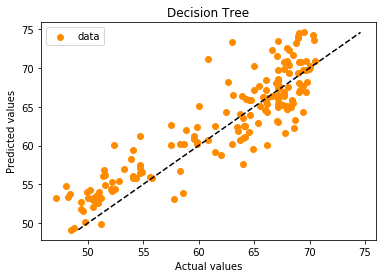

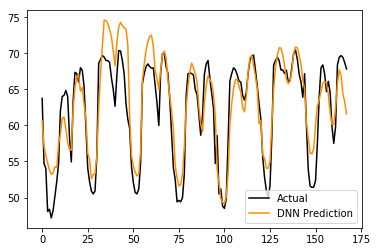

In [21]:
#train and cross-validate model
model_dl, MAP_error_dl = dnn_prediction([x_train_c, y_train, x_test_c, y_test])

# Deep Learning Day-Ahead Forecast


In [22]:
dnn_pred_prediction = list(model_dl.predict(x_pred_c))

# Choose best prediction and save to xls

In [23]:
model_1_map = MAP_error_rf
model_2_map = MAP_error_dl
models_list = [model_1_map, model_2_map]
minIndex = models_list.index(min(models_list))

models_output = np.array([rf_prediction, 
                          dnn_pred_prediction])

import csv

hour_column = pd.DataFrame(list(range(1,25)), columns = ['Hour'])

csvfile_0 = pd.DataFrame(list(models_output[minIndex,:]), columns = ['Best'])

csvfile_1 = pd.DataFrame(rf_prediction, columns = ['RF'])

csvfile_2 = pd.DataFrame(dnn_pred_prediction, columns = ['DNN'])


cvfileall = pd.concat([hour_column, csvfile_0, csvfile_1, csvfile_2], axis = 1)

prediction_date = pred_date_END+timedelta(1)
prediction_date = prediction_date.strftime('%Y-%m-%d')

cvfileall.to_excel('forecast_'+prediction_date+'.xlsx', sheet_name='sheet1', index=False)